# AAI-540 Group 6 Final Project

Authors: Alden Caterio, Gary Takahashi, Paul Parks

In [2]:
!pip install --disable-pip-version-check -q PyAthena
!pip install --disable-pip-version-check -q awswrangler
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 5.2 MB/s eta 0:00:00:00:01


# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import boto3
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
from time import gmtime, strftime, time
from botocore.client import ClientError
from pyathena import connect
import pandas as pd
import boto3
import sagemaker
import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## AWS S3 and Athena Setup

### Collect a raw data set and store it in an S3 Datalake.

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-692501163596


In [5]:
response = None
try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': 'HKF57251ZYP73CEY', 'HostId': 'cAKVmEfYg+KUhDkk7K6Ppr/z6al7QSLW/ZSitVJArFzdtZ9u/9b/kArTMxTGaA2EorxXEl9vvIg=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'cAKVmEfYg+KUhDkk7K6Ppr/z6al7QSLW/ZSitVJArFzdtZ9u/9b/kArTMxTGaA2EorxXEl9vvIg=', 'x-amz-request-id': 'HKF57251ZYP73CEY', 'date': 'Mon, 23 Sep 2024 23:13:26 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [6]:
filename = 'CEAS_08.csv'
local_csv_path = './dataset/' + filename

parquet_filename = filename.replace('.csv', '.parquet')  # Parquet file name
local_parquet_path = os.path.join('./dataset/', parquet_filename)

df = pd.read_csv(local_csv_path)
# Convert the CSV to Parquet
df['urls'] = df['urls'].astype(str)
df.to_parquet(local_parquet_path, engine='pyarrow')

folder_in_s3 = 'Dataset/'
s3_destination_path = f's3://{bucket}/{folder_in_s3}{parquet_filename}'
s3_destination_dir = f's3://{bucket}/{folder_in_s3}'

s3 = boto3.client('s3')

bucket_name = bucket
key = f'{folder_in_s3}{parquet_filename}'

s3.upload_file(local_parquet_path, bucket_name, key)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
if 'Contents' in response:
    print(f"File '{local_parquet_path}' uploaded successfully to '{s3_destination_path}'")
else:
    print(f"Failed to upload file to {s3_destination_path}")

File './dataset/CEAS_08.parquet' uploaded successfully to 's3://sagemaker-us-east-1-692501163596/Dataset/CEAS_08.parquet'


### Set up Athena tables to enable cataloging and querying of your data.

In [7]:
database_name = "spam_detection_db"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

/tmp/ipykernel_21/4249963361.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [8]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_21/1677879827.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,dsoaws
2,music_db
3,sagemaker_featurestore
4,spam_detection_db


In [9]:
table_name = "emails"
statement = f"""DROP TABLE IF EXISTS {database_name}.{table_name}"""
pd.read_sql(statement, conn)

/tmp/ipykernel_21/3526594799.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [10]:
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
    sender string,
    receiver string,
    date string,
    subject string,
    body string,
    label int,
    urls string
)
STORED AS PARQUET
LOCATION '{s3_destination_dir}'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

pd.read_sql(statement, conn)

/tmp/ipykernel_21/1329176703.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [11]:
statement = f"SHOW TABLES in {database_name}"

df_show = pd.read_sql(statement, conn)
print(df_show.head(5))

if table_name in df_show.values:
    print("[OK] Table created successfully.")
else:
    print("[ERROR] Table creation failed.")

/tmp/ipykernel_21/1698154721.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


  tab_name
0   emails
[OK] Table created successfully.


In [12]:
statement = f"""SELECT COUNT(*) AS total_rows
FROM {database_name}.{table_name}"""

result = pd.read_sql(statement, conn)
result.head(5)

/tmp/ipykernel_21/1710626760.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,total_rows
0,39154


In [13]:
statement = f"""SELECT * FROM {database_name}.{table_name} LIMIT 10"""

result = pd.read_sql(statement, conn)
result.head(10)

/tmp/ipykernel_21/1869399943.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
5,Caroline Aragon <dwthaidomainnamesm@thaidomain...,user7-ext5@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 05:31:22 +0600",From Caroline Aragon,\n\n\n\n\nYo wu urS mo ou go rc ebo eForM rgi ...,1,0
6,Replica Watches <jhorton@thebakercompanies.com>,user2.10@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 21:44:01 +0000",Replica Watches,We have fake Swiss Men's and Ladie's Replica \...,1,0
7,Daily Top 10 <acidirev_1972@tcwpg.com>,user2.3@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:41:14 -0300",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
8,qydlqcws-iacfym@issues.apache.org,xrh@spamassassin.apache.org,"Tue, 05 Aug 2008 15:31:03 -0800",[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0,1
9,Daily Top 10 <orn|dent_1973@musicaedischi.it>,user7@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 00:31:38 +0100",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1


## AWS FeatureStore

### Test Train Split
Split your feature data into training (~40%), test (~10%) validation (~10%) datasets.
Reserve some data for “production data” (~40%).

In [14]:
feature_store_data = wr.athena.read_sql_query(f"SELECT * FROM {database_name}.{table_name}", database=database_name)

In [15]:
# Set up AWS clients and SageMaker session
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)
feature_store_session = Session(boto_session=boto_session, sagemaker_client=sagemaker_client, sagemaker_featurestore_runtime_client=featurestore_runtime)

# Define the S3 bucket for the offline store
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-spamdetection"

# Set up IAM role for SageMaker
role = get_execution_role()

In [16]:
# Create a FeatureGroup for the data
spamdetection_feature_group_name = "spamdetection-feature-group" + strftime("%d-%H-%M-%S", gmtime())
spamdetection_feature_group = FeatureGroup(name=spamdetection_feature_group_name, sagemaker_session=feature_store_session)

# Cast necessary columns to the right types
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

cast_object_to_string(feature_store_data)

In [17]:
from time import sleep
import uuid
current_time_sec = int(time())

feature_store_data['primary_key'] = [str(uuid.uuid4()) for _ in range(len(feature_store_data))]
feature_store_data['event_time'] = pd.Series([current_time_sec] * len(feature_store_data), dtype='float64')

# Record identifier and event time feature names
record_identifier_feature_name = 'primary_key'
event_time_feature_name = 'event_time'

# Load feature definitions from the DataFrame
spamdetection_feature_group.load_feature_definitions(data_frame=feature_store_data)

# Create the FeatureGroup in the SageMaker FeatureStore
spamdetection_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)


# Wait for the FeatureGroup to be created
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=spamdetection_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup spamdetection-feature-group23-23-13-50 successfully created.


## Exploratory Data Analysis

In [18]:
df = feature_store_data

In [19]:
# Display the first few rows of the dataset
df.head()

,sender,receiver,date,subject,body,label,urls,primary_key,event_time
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,831b3a7e-5050-4878-a981-8bd693392e44,1.727133e+09
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,1,edaf20af-29c6-45aa-aea0-31e65ed1929a,1.727133e+09
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,c623175a-0a95-43ef-93c8-d349a21bfaa0,1.727133e+09
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,a654e3d1-fbc2-4496-ab9f-17d5e88eaf06,1.727133e+09
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,1,20191a8e-871e-4159-ba3a-8a78e025d779,1.727133e+09


In [20]:
# Get the shape of the dataset (number of rows and columns)
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 39154 rows and 9 columns.


In [21]:
# Get information about data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sender       39154 non-null  string 
 1   receiver     38692 non-null  string 
 2   date         39154 non-null  string 
 3   subject      39126 non-null  string 
 4   body         39154 non-null  string 
 5   label        39154 non-null  Int32  
 6   urls         39154 non-null  string 
 7   primary_key  39154 non-null  object 
 8   event_time   39154 non-null  float64
dtypes: Int32(1), float64(1), object(1), string(6)
memory usage: 2.6+ MB


In [22]:
# Get statistical summary of numerical columns
df.describe()

,label,event_time
count,39154.0,3.915400e+04
mean,0.557848,1.727133e+09
std,0.496649,0.000000e+00
min,0.0,1.727133e+09
25%,0.0,1.727133e+09
50%,1.0,1.727133e+09
75%,1.0,1.727133e+09
max,1.0,1.727133e+09


In [23]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sender           0
receiver       462
date             0
subject         28
body             0
label            0
urls             0
primary_key      0
event_time       0
dtype: int64


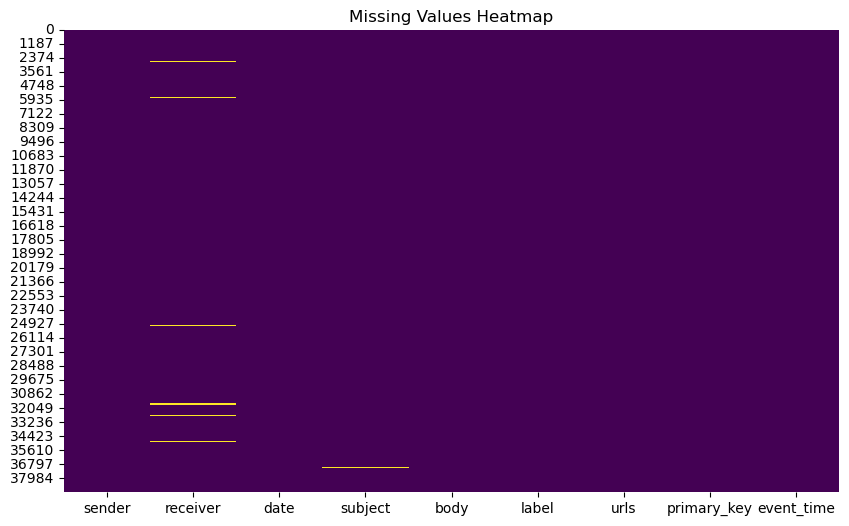

In [24]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [25]:
# Get the distribution of the target variable 'label'
label_counts = df['label'].value_counts()
print("Distribution of target variable 'label':")
print(label_counts)

Distribution of target variable 'label':
label
1    21842
0    17312
Name: count, dtype: Int64


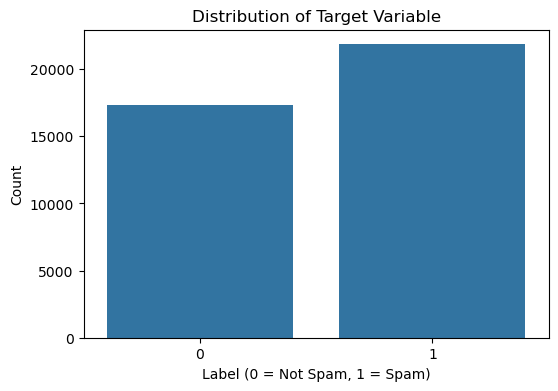

In [26]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()

In [27]:
# Check the number of unique senders and receivers
num_senders = df['sender'].nunique()
num_receivers = df['receiver'].nunique()
print(f"Number of unique senders: {num_senders}")
print(f"Number of unique receivers: {num_receivers}")

Number of unique senders: 24578
Number of unique receivers: 3693


In [28]:
# Top 10 most frequent senders
top_senders = df['sender'].value_counts().head(10)
print("Top 10 senders:")
print(top_senders)

Top 10 senders:
sender
qydlqcws-iacfym@issues.apache.org                 462
Guido van Rossum <hoauf@python.org>               295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>      276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>      208
Aaron Kulkis <cmiqlkx91@hotpop.com>               183
Rafael Garcia-Suarez <pvhuhqgncrxnu@gmail.com>    158
Christian Heimes <wluhe@cheimes.de>               152
Barry Warsaw <pjaxq@python.org>                   131
iybz@pobox.com                                    124
Per Jessen <uee@computer.org>                     113
Name: count, dtype: Int64


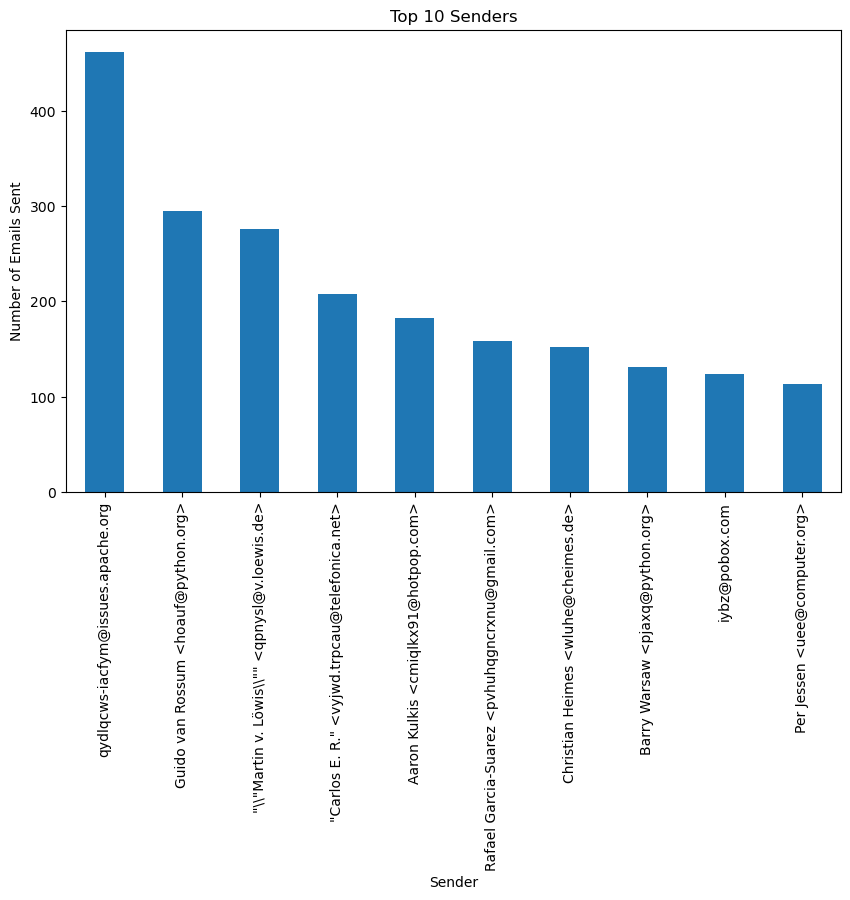

In [29]:
# Visualize top senders
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar')
plt.title('Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Number of Emails Sent')
plt.show()

In [30]:
# Create new features for the lengths of text fields
df['subject_length'] = df['subject'].astype(str).apply(len)
df['body_length'] = df['body'].astype(str).apply(len)
df['urls_length'] = df['urls'].astype(str).apply(len)

In [31]:
# Statistical summary of the text lengths
text_length_summary = df[['subject_length', 'body_length', 'urls_length']].describe()
print("Statistical summary of text lengths:")
print(text_length_summary)

Statistical summary of text lengths:
       subject_length    body_length  urls_length
count    39154.000000   39154.000000      39154.0
mean        38.899397    1571.079813          1.0
std         20.764513    3615.810576          0.0
min          1.000000      14.000000          1.0
25%         25.000000     224.000000          1.0
50%         35.000000     570.000000          1.0
75%         50.000000    1643.000000          1.0
max        285.000000  143996.000000          1.0


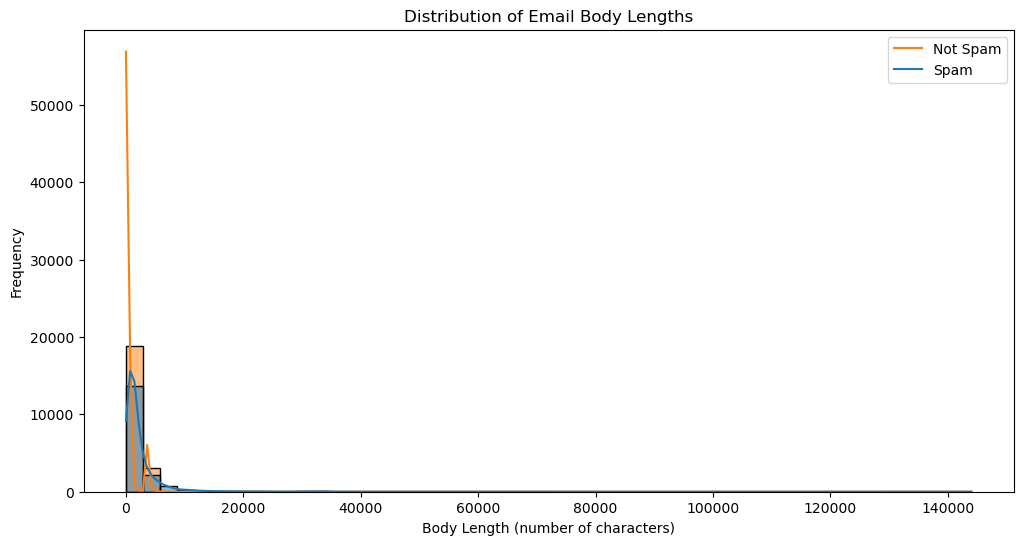

In [32]:
# Visualize the distribution of body lengths for spam and non-spam emails
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='body_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Email Body Lengths')
plt.xlabel('Body Length (number of characters)')
plt.ylabel('Frequency')
plt.legend(labels=['Not Spam', 'Spam'])
plt.show()

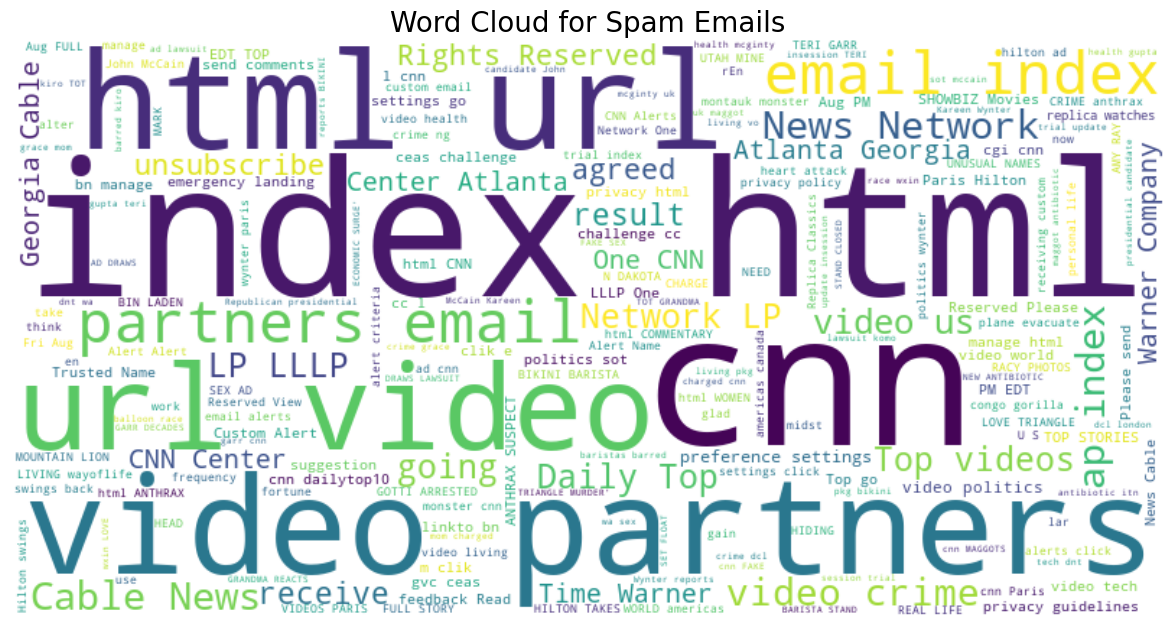

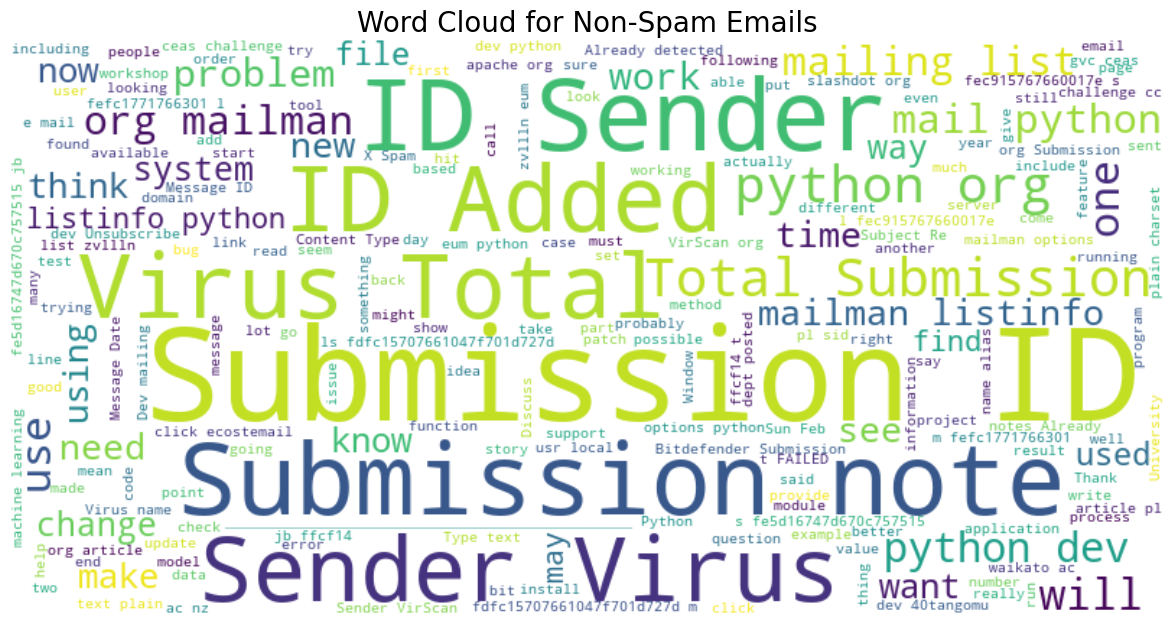

In [33]:
# Generate word clouds for spam and non-spam emails
spam_emails = df[df['label'] == 1]
non_spam_emails = df[df['label'] == 0]

def generate_wordcloud(text_data, title):
    text = ' '.join(text_data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for spam emails
generate_wordcloud(spam_emails['body'], 'Word Cloud for Spam Emails')

# Word cloud for non-spam emails
generate_wordcloud(non_spam_emails['body'], 'Word Cloud for Non-Spam Emails')

In [35]:
# Create a DataFrame with numerical features
numerical_features = ['subject_length', 'body_length', 'urls_length']
numerical_df = df[numerical_features + ['label']]

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                subject_length  body_length  urls_length     label
subject_length        1.000000     0.063805          NaN -0.393957
body_length           0.063805     1.000000          NaN -0.239108
urls_length                NaN          NaN          NaN       NaN
label                -0.393957    -0.239108          NaN  1.000000


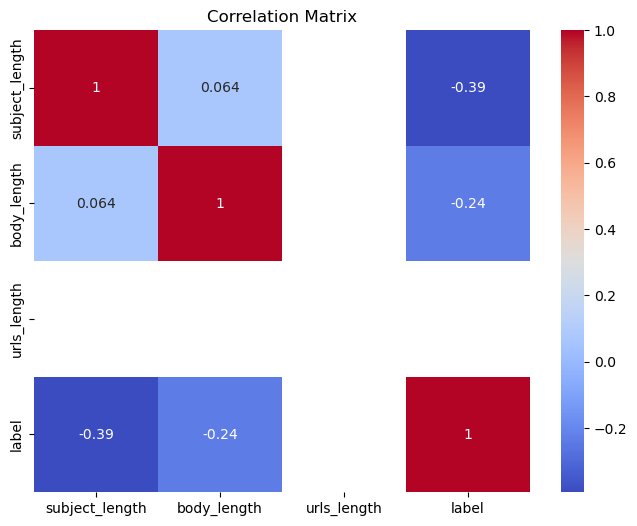

In [36]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Benchmark Model

In [38]:

# Split 40% of the data for production and the remaining 60% for further splitting
df_remaining, df_production = train_test_split(df, test_size=0.40, random_state=42)

# From the remaining 60%, split 66.67% for training (which is 40% of total) and 33.33% for test + validation (20% of total)
df_train, df_test_validation = train_test_split(df_remaining, test_size=0.33, random_state=42)

# Split the remaining test + validation data into test (10%) and validation (10%)
df_test, df_validation = train_test_split(df_test_validation, test_size=0.50, random_state=42)

# Print the sizes of each split to confirm
print(f"Training data: {len(df_train)} rows")
print(f"Test data: {len(df_test)} rows")
print(f"Validation data: {len(df_validation)} rows")
print(f"Production data: {len(df_production)} rows")

Training data: 15739 rows
Test data: 3876 rows
Validation data: 3877 rows
Production data: 15662 rows


In [39]:
# Compute simple features for training data
df_train['body_length'] = df_train['body'].astype(str).apply(len)
df_train['has_free'] = df_train['body'].astype(str).str.contains('free', case=False, na=False).astype(int)

# Compute features for test data
df_test['body_length'] = df_test['body'].astype(str).apply(len)
df_test['has_free'] = df_test['body'].astype(str).str.contains('free', case=False, na=False).astype(int)

In [40]:
# Save the training data to CSV
df_train[['body_length', 'has_free', 'label']].to_csv('train.csv', index=False)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

prefix = 'benchmark-model'

train_input_path = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')

print(f'Training data uploaded to: {train_input_path}')

Training data uploaded to: s3://sagemaker-us-east-1-692501163596/benchmark-model/train/train.csv


### Train script
the following script will be output and used by the estimator

In [41]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib

from sklearn.linear_model import LogisticRegression

def model_fn(model_dir):
    """Load the model for inference"""
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # SageMaker-specific arguments
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    
    args = parser.parse_args()
    
    # Read the training data
    train_data = pd.read_csv(os.path.join(args.train, 'train.csv'))
    
    # Separate features and target
    X_train = train_data[['body_length', 'has_free']]
    y_train = train_data['label']
    
    # Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))

Writing train.py


### Train the model

In [42]:
from sagemaker.sklearn.estimator import SKLearn

role = sagemaker.get_execution_role()

sklearn_estimator = SKLearn(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    framework_version='0.23-1',
    py_version='py3',
    output_path=f's3://{bucket}/{prefix}/output'
)

# Run the training job
sklearn_estimator.fit({'train': train_input_path})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-09-23-23-24-56-508


2024-09-23 23:24:57 Starting - Starting the training job...
2024-09-23 23:25:13 Starting - Preparing the instances for training...
2024-09-23 23:25:44 Downloading - Downloading input data...
2024-09-23 23:26:09 Downloading - Downloading the training image...
2024-09-23 23:26:50 Training - Training image download completed. Training in progress..2024-09-23 23:26:54,419 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-09-23 23:26:54,423 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-23 23:26:54,469 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-09-23 23:26:54,642 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-23 23:26:54,655 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-23 23:26:54,669 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-23 23:

### Deploy the trained model

In [43]:
# Deploy the model to an endpoint
predictor = sklearn_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-09-23-23-28-24-888
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-09-23-23-28-24-888
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-09-23-23-28-24-888


------!

### Run inference for evaluation

In [44]:
# Prepare test data
X_test = df_test[['body_length', 'has_free']]
y_test = df_test['label']

In [46]:
# Set the serializer and deserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

# Make predictions
predictions = predictor.predict(X_test.to_csv(header=False, index=False))
predicted_labels = [int(float(prediction)) for prediction in predictions]

In [47]:
print("Predictions:", predictions)

Predictions: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,

### Metrics

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Benchmark Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Benchmark Model Performance:
Accuracy: 0.6300
Precision: 0.6159
Recall: 0.8671
F1 Score: 0.7202


### Cleanup to avoid AWS fees

In [49]:
# Delete the endpoint to avoid charges
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-scikit-learn-2024-09-23-23-28-24-888
INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2024-09-23-23-28-24-888
